# Imports

In [20]:
import pandas as pd
import numpy as np

import networkx as nx

from karateclub import DeepWalk 
from karateclub import Node2Vec

import matplotlib.pyplot as plt

%matplotlib inline

## Load `e_coli_core` from cobra for reference

In [21]:
from cobra.io import load_model

model = load_model('textbook')
model

Name,e_coli_core
Memory address,7f24f4f46d90
Number of metabolites,72
Number of reactions,95
Number of genes,137
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


## Load edge list file

In [22]:
# path_to_file = '../data/queries/query-result-full.xlsx'

# path_to_file = '../data/queries/query-result-full - met2met.csv'

path_to_file = '../data/queries/query-result-full - met2react.csv'

try: 
    df = pd.read_csv(path_to_file)
    df.rename(columns = {'[reaction]':'source', 'met': 'target'}, inplace = True)
    df.rename(columns = {'[metabolite]':'source', 'metabolite2': 'target'}, inplace = True)
    df.rename(columns = {'[metabolite]':'source', 'metabolite': 'target'}, inplace = True)
except UnicodeDecodeError:
    df = pd.read_excel(path_to_file)
    df.rename(columns = {'start':'source', 'reaction': 'target'}, inplace = True)
    

for col in df.columns:
    df[col] = df[col].apply(lambda row : row[3:] )

df

,source,target
0,reaction_acald,metabolite_h_c
1,reaction_acald,metabolite_accoa_c
2,reaction_acald,metabolite_nadh_c
3,reaction_acaldt,metabolite_acald_c
4,reaction_ackr,metabolite_actp_c
...,...,...
485,metabolite_succ_e,reaction_succt3
486,metabolite_succ_e,reaction_succt2_2
487,metabolite_succ_e,reaction_ex_succ_e
488,metabolite_succoa_c,reaction_sucoas


### Keep `source` / `target` types (metabolite / reaction)

In [23]:
df['source_type'] = df['source'].apply(lambda row : row.split('_')[0])
df['target_type'] = df['target'].apply(lambda row : row.split('_')[0])

# for col in ['source', 'target']:
#     df[col] = df[col].apply(lambda row : row.replace('metabolite_', ''))
#     df[col] = df[col].apply(lambda row : row.replace('reaction_', ''))    

df.head()

,source,target,source_type,target_type
0,reaction_acald,metabolite_h_c,reaction,metabolite
1,reaction_acald,metabolite_accoa_c,reaction,metabolite
2,reaction_acald,metabolite_nadh_c,reaction,metabolite
3,reaction_acaldt,metabolite_acald_c,reaction,metabolite
4,reaction_ackr,metabolite_actp_c,reaction,metabolite


In [24]:
df.shape

(490, 4)

### Which `metabolites` / `reactions` are missing from the `graph`?

## Metabolites

In [ ]:
m_s = df[df['target_type'] == 'metabolite']['target'].unique()
m_t = df[df['source_type'] == 'metabolite']['source'].unique()

elements = np.append(m_s, m_t)
print(np.unique(elements))
print(len(np.unique(elements)))

In [ ]:
cobra_elements = np.array([m.id.lower() for m in model.metabolites])
print(cobra_elements)
print(len(cobra_elements))

In [ ]:
uncommon_values = set(elements) ^ set(cobra_elements)
uncommon_values

## Reactions

In [ ]:
r_s = df[df['target_type'] == 'reaction']['target'].unique()
r_t = df[df['source_type'] == 'reaction']['source'].unique()

elements = np.append(r_s, r_t)
print(np.unique(elements))
print(len(np.unique(elements)))

In [ ]:
cobra_elements = np.array([m.id.lower() for m in model.reactions])
print(cobra_elements)
print(len(cobra_elements))

In [ ]:
uncommon_values = set(elements) ^ set(cobra_elements)
uncommon_values

## Create Graph from `edge_list`

#### Create a `df` only with `reaction -> metabolite` relationships

In [25]:
df_rxn_to_met = df[(df['source_type'] == 'reaction') & (df['target_type'] == 'metabolite')
                  | (df['source_type'] == 'metabolite') & (df['target_type'] == 'reaction')]
df_rxn_to_met

,source,target,source_type,target_type
0,reaction_acald,metabolite_h_c,reaction,metabolite
1,reaction_acald,metabolite_accoa_c,reaction,metabolite
2,reaction_acald,metabolite_nadh_c,reaction,metabolite
3,reaction_acaldt,metabolite_acald_c,reaction,metabolite
4,reaction_ackr,metabolite_actp_c,reaction,metabolite
...,...,...,...,...
485,metabolite_succ_e,reaction_succt3,metabolite,reaction
486,metabolite_succ_e,reaction_succt2_2,metabolite,reaction
487,metabolite_succ_e,reaction_ex_succ_e,metabolite,reaction
488,metabolite_succoa_c,reaction_sucoas,metabolite,reaction


In [26]:
G = nx.from_pandas_edgelist(df_rxn_to_met, source='source', target='target',
                           create_using=nx.DiGraph)
print(G.is_directed())

print(G.number_of_edges())
print(G.number_of_nodes())

True
490
155


In [28]:
shortest_path = nx.shortest_path(G, source='metabolite_g6p_c', target='metabolite_succ_c') 
print(shortest_path)

['metabolite_g6p_c', 'reaction_pgi', 'metabolite_f6p_c', 'reaction_icl', 'metabolite_succ_c']


In [57]:
paths = nx.all_simple_paths(G, source='metabolite_g6p_c', target='metabolite_succ_c') 

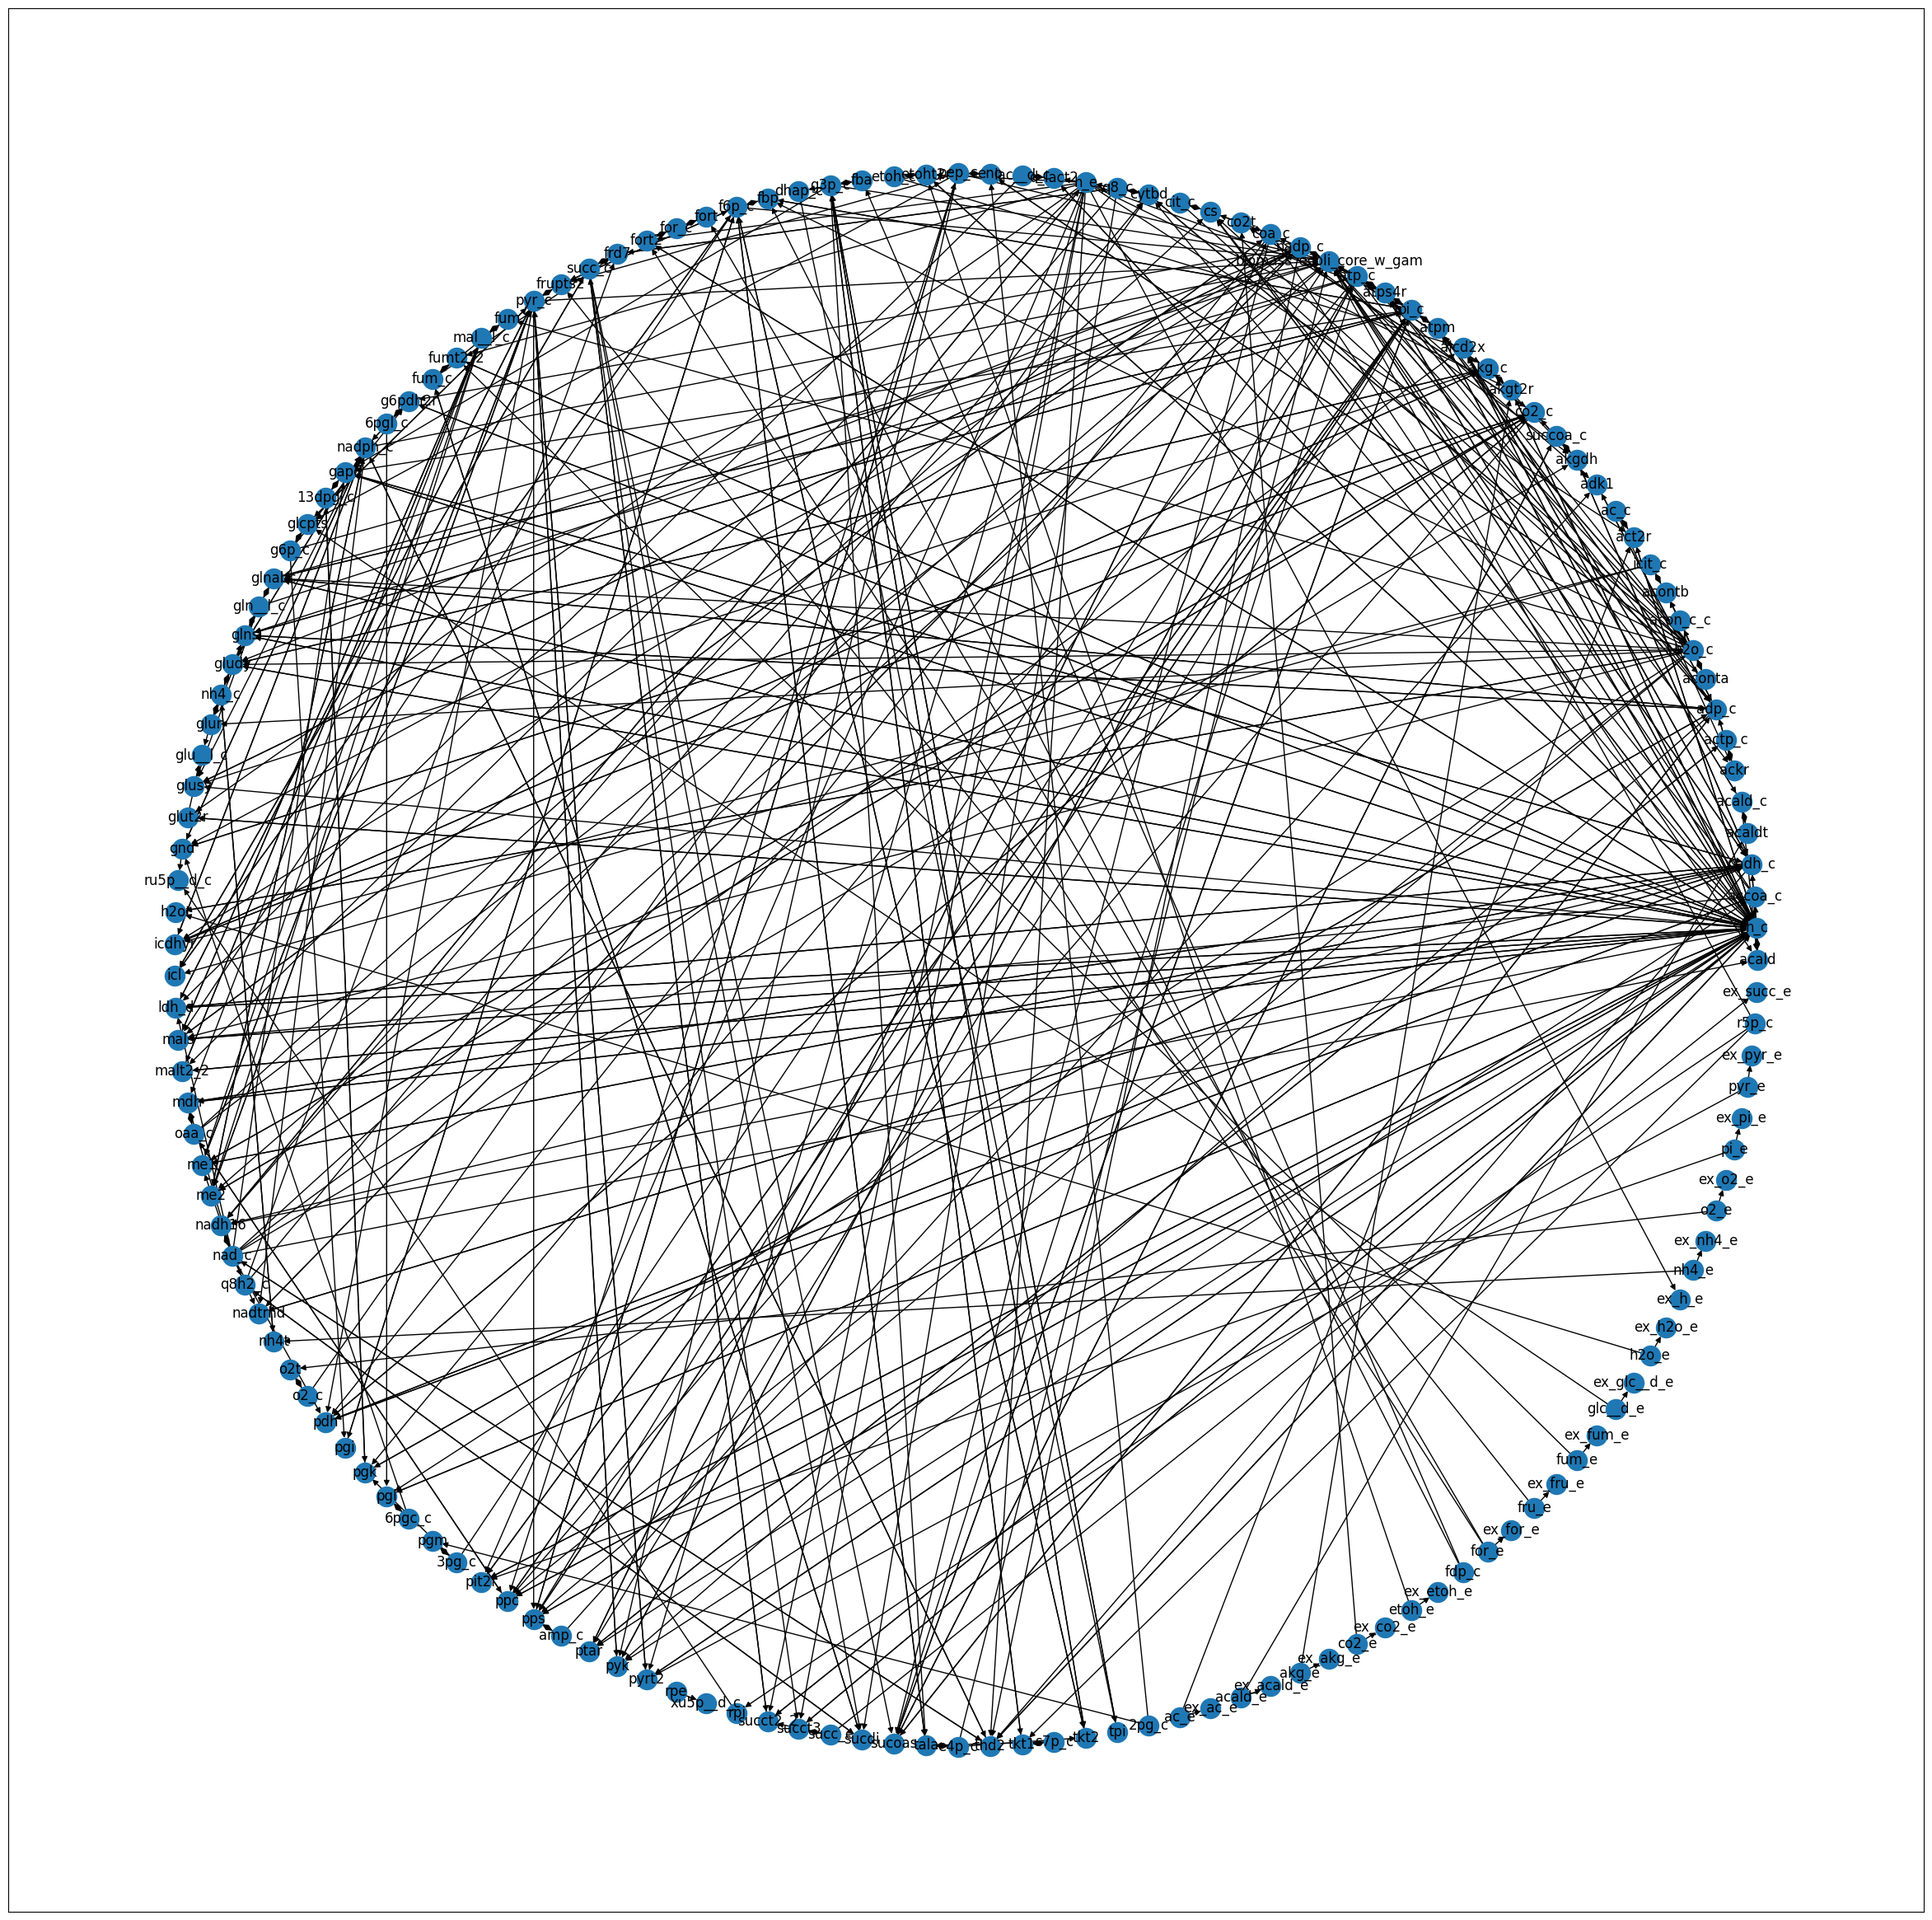

In [15]:
plt.figure(figsize=(30,30))
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos)

#### Create a `df` only with `metabolite -> metabolite` relationships

In [ ]:
df_met_to_met = df[(df['source_type'] == 'metabolite') & (df['target_type'] == 'metabolite')]
df_met_to_met

#### Create Graph

In [ ]:
G = nx.from_pandas_edgelist(df_met_to_met, source='source', target='target',
                           create_using=nx.DiGraph)
print(G.is_directed())

In [ ]:
G.number_of_nodes()

In [ ]:
G.number_of_edges()

In [ ]:
paths = nx.shortest_path(G, source='glc__d_e', target='succ_c') 
print(list(paths))

In [ ]:
paths = nx.all_simple_paths(G, source='glc__d_e', 
                            target='succ_c') 

In [ ]:
for i in paths:
    print(i)

### Plot Graph

In [ ]:
plt.figure(figsize=(30,30))
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos)

# Study created Graph